In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

service = QiskitRuntimeService()


In [5]:
num_qubits = 7
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)
backend

<IBMBackend('ibm_brisbane')>

In [ ]:
class RepetitionCode:
    def __init__(self, d=3, repetitions=2):
        """
        Initialiserar repetitionskoden.
        :param d: Kodens distans
        :param repetitions: Syndrom mätningar
        """
        self.d = d
        self.repetitions = repetitions
        
        # Kvantregister
        self.qreg_data = QuantumRegister(d)  # Kvantbitar
        self.qreg_measure = QuantumRegister(d - 1, name="ancillas")  # Ancilla för syndrommätning
        
        # Klassiska register
        self.creg_data = ClassicalRegister(d, name="final_state")  # Slutlig mätning av datakvbit
        self.creg_syndrome = [
            ClassicalRegister(d - 1, name=f"syndrome_{i+1}") for i in range(repetitions)
        ]

        # Skapa kvantkrets
        self.qc = QuantumCircuit(
            self.qreg_data, self.qreg_measure, self.creg_data, *self.creg_syndrome
        )

    def initialize_qubits(self):
        """Initierar kvantbiten i |1> tillståndet."""

        self.qc.x(self.qreg_data[0]) #X grinden byter |0> -> |1>, eller |1> -> |0>
        self.qc.barrier()            #Barriär tvingar kvantdatorn att göra allt innan (X grinden), innan den kan gå vidare
    
    def bit_flip_encoding(self):
        """Kodning av den logiska kvantbiten."""

        for i in range(1, self.d):  #Sprider tillståndet till de andra kvantbitarna
            self.qc.cx(self.qreg_data[0], self.qreg_data[i]) 
        self.qc.barrier()

    def syndrome_measurement(self):
        """Mäter syndrom och lagrar i klassiska register."""
        for r in range(self.repetitions):           # Antal repetitioner
            for i in range(self.d - 1):             # Syndrom
                self.qc.cx(self.qreg_data[i], self.qreg_measure[i])     
                self.qc.cx(self.qreg_data[i + 1], self.qreg_measure[i])
            self.qc.barrier()
            self.qc.measure(self.qreg_measure, self.creg_syndrome[r])
            self.qc.barrier()

    def final_measurement(self):
        """Mäter slutliga tillståndet av datakvbit."""
        self.qc.measure(self.qreg_data, self.creg_data)

    def build_circuit(self):
        """Bygger hela kvantkretsen."""
        self.initialize_qubits()
        self.bit_flip_encoding()
        self.syndrome_measurement()
        self.final_measurement()
        return self.qc


SyntaxError: invalid syntax (2144063613.py, line 29)

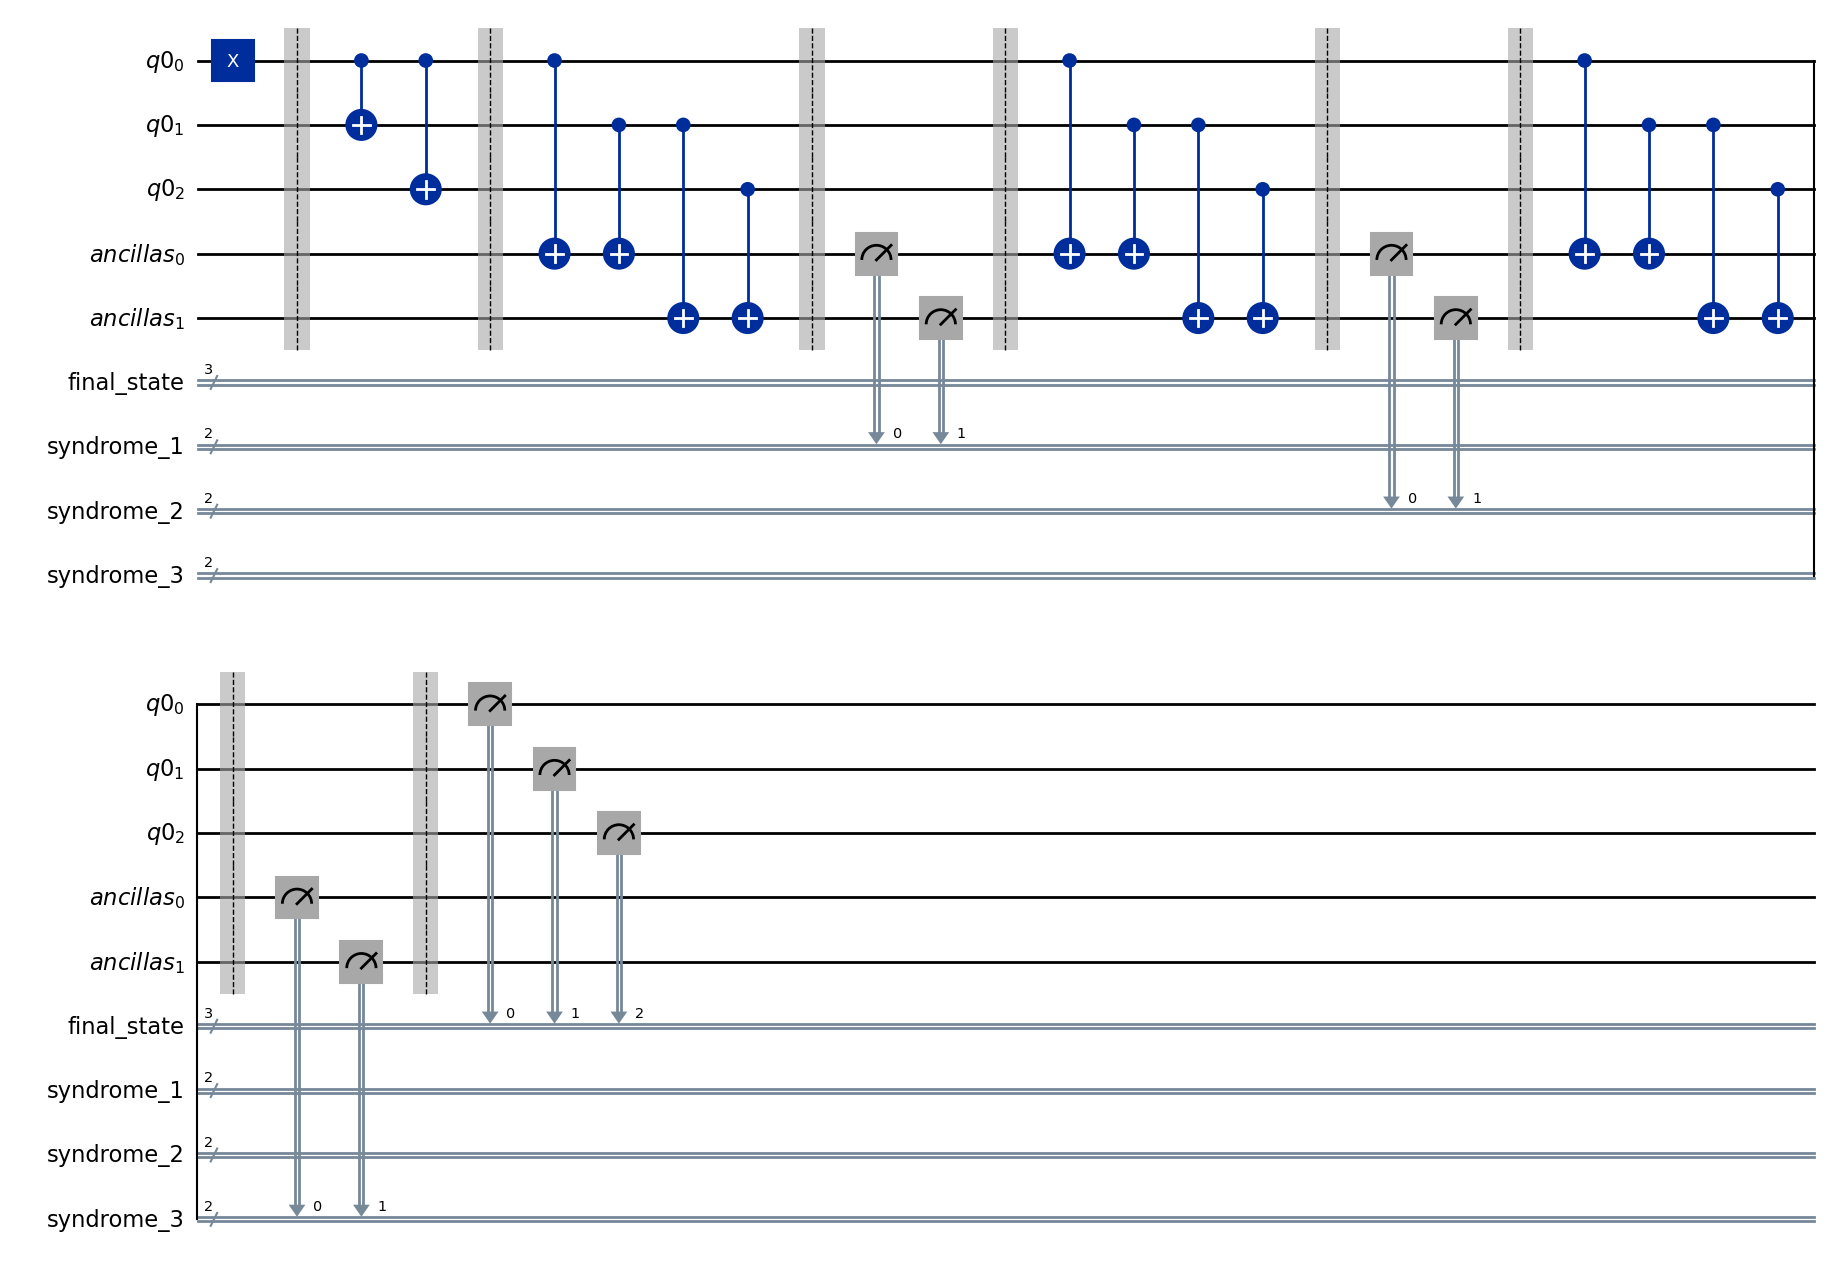

In [3]:
repetition_code = RepetitionCode(d=3, repetitions=3)
qc = repetition_code.build_circuit()
qc.draw(output='mpl',style='iqp')

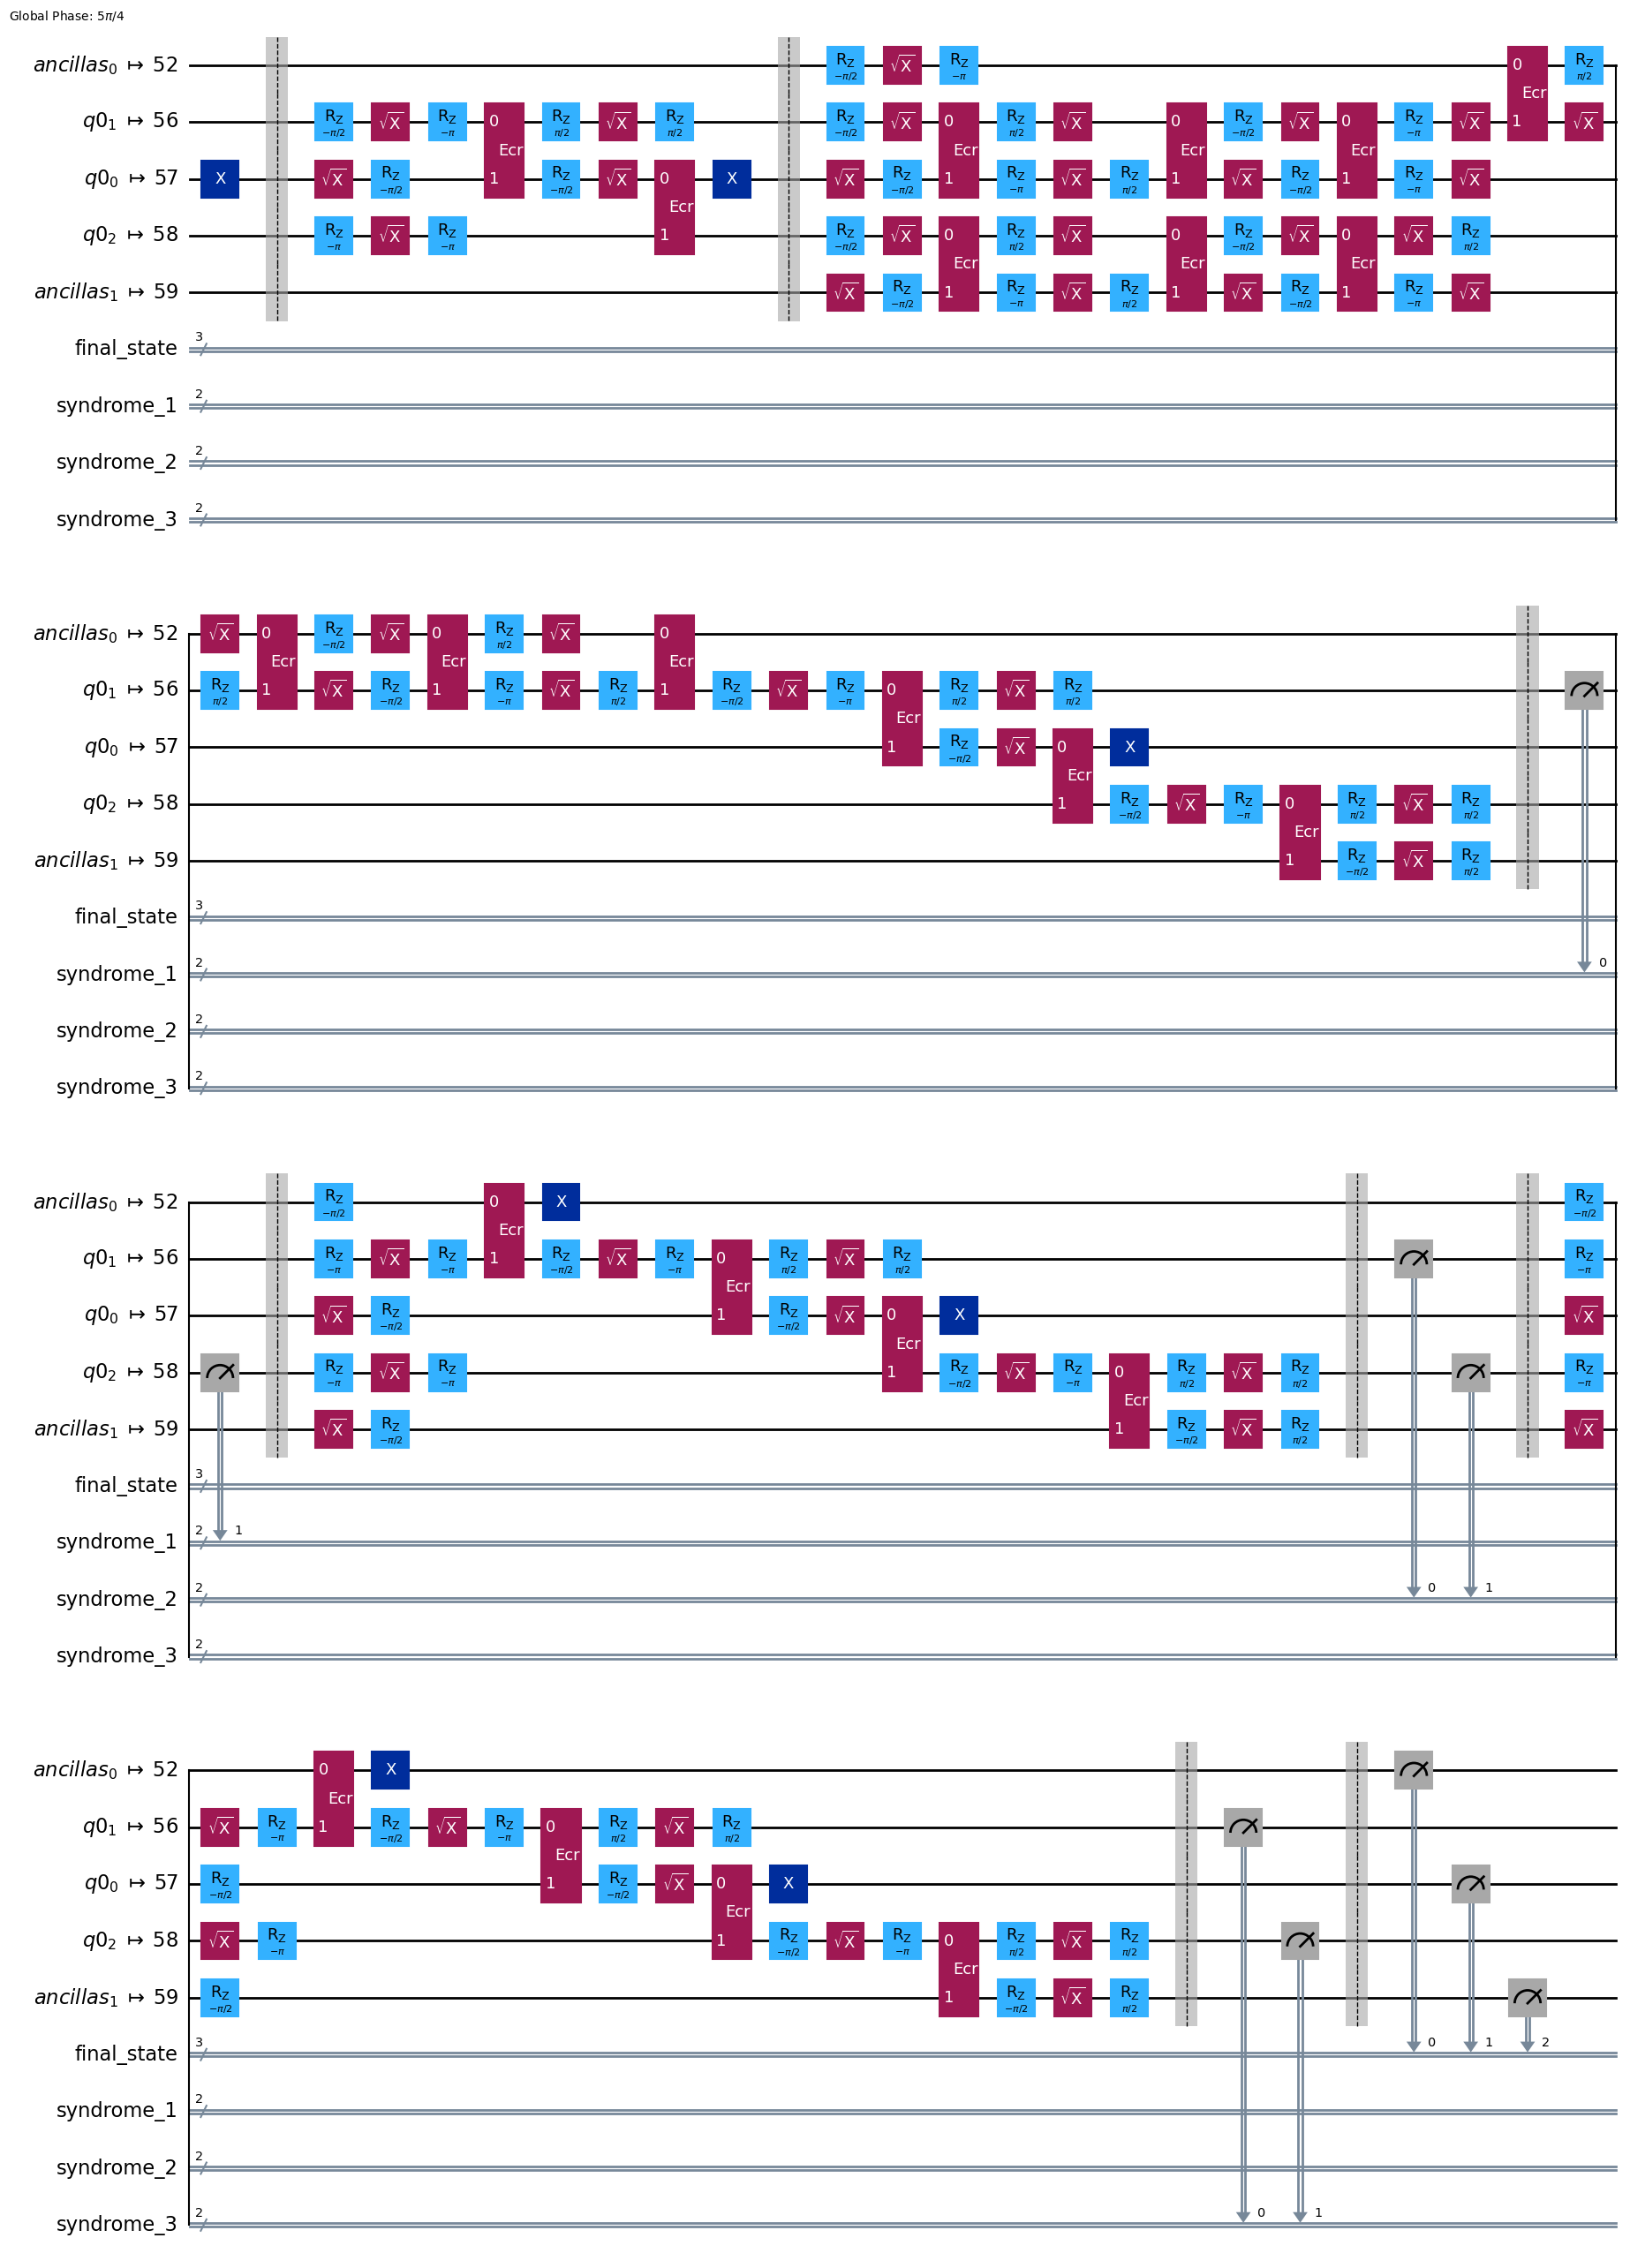

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', style='iqp', idle_wires=False)

In [8]:
repetition_code = RepetitionCode(d=3, repetitions=3)
qc = repetition_code.build_circuit()
no_correction_circuit = qc

isa_no_correction_circuit = pm.run(no_correction_circuit)

In [ ]:
sampler_no_correction = Sampler(backend)
job_no_correction = sampler_no_correction.run([isa_no_correction_circuit], shots=1000)
result_no_correction = job_no_correction.result()[0]